In [1]:
# pip install yellowbrick

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
import textwrap
import missingno as msno
from sklearn.decomposition import PCA,KernelPCA
from sklearn.manifold import MDS,TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import prince
from yellowbrick.cluster import KElbowVisualizer

In [3]:
os.chdir('D:\\MIT_Micromaster\\ELSA')

In [4]:
dforg = pd.read_csv('Copy of Data - encuesta organizacional 2023.csv')
dfper = pd.read_csv('data_adicional.csv')

In [5]:
per = pd.read_excel('Copy of Preguntas - ELSA 4.xlsx','Preguntas - EP',usecols=['Enunciado Pregunta','Categoria','Serial Code'])
org = pd.read_excel('Copy of Preguntas - ELSA 4.xlsx','Preguntas - EO',usecols=['Enunciado Pregunta','Categoria','Serial Code'])
org = org.iloc[0:136]

In [6]:
per.columns = ['pregunta','categoria','code']
org.columns = ['pregunta','categoria','code']

per['code'] = per['code'].str.lower()
org['code'] = org['code'].str.lower()

In [7]:
def funcion(x):
    if x<=199:
        return 'small'
    elif x<=999:
        return 'medium'
    else:
        return 'large'

# dfper['tamaño'] = dfper.apply(lambda x: funcion(x['poblacion']),axis=1)

# Analisis missing

In [8]:
dfper = dfper[dfper['ip_002'].notnull()].reset_index(drop=True).copy()

In [9]:
# Idea continuar la separacion. Y en el dataset acoso=0 y testigo=0 agrupar por su concepcion y percepcion.

# Creando target

In [10]:
acoso_tecnico = [col for col in dfper.columns if 'at_' in col]
dfper['Acoso_Tecnico'] = dfper[acoso_tecnico].apply(lambda row: 1 if any(row == 'Sí, me ha pasado.') else 0, axis=1)

In [11]:
testigos_tecnicos = [col for col in dfper.columns if 'tt_' in col]
dfper['Testigo_Tecnico'] = dfper[testigos_tecnicos].apply(lambda row: 1 if any(row == 'Sí, he sido testigo.') else 0, axis=1)

In [12]:
dfper['Acoso_Declarado'] = dfper[['ad_001','ad_014']].apply(lambda row: 1 if any(row == 'Sí, me ha pasado.') else 0, axis=1)

In [13]:
dfper['Testigo_Declarado'] = dfper[['td_001']].apply(lambda row: 1 if any(row == 'Sí, he sido testigo de hostigamiento o acoso sexual.') else 0, axis=1)

In [14]:
acoso_total = [col for col in dfper.columns if 'Acoso' in col]
dfper['Acoso_Total'] = dfper[acoso_total].apply(lambda row: 1 if any(row == 1) else 0, axis=1)

In [15]:
dfper.groupby(['Acoso_Total','Acoso_Tecnico','Acoso_Declarado']).agg(CTD=('measurement_process_id','count'))

CTD
Acoso_Total Acoso_Tecnico Acoso_Declarado       
0           0             0                21758
1           0             1                 3233
            1             0                 3331
                          1                  875

In [16]:
testigo_total = [col for col in dfper.columns if 'Testigo' in col]
dfper['Testigo_Total'] = dfper[testigo_total].apply(lambda row: 1 if any(row == 1) else 0, axis=1)

In [17]:
dfper.groupby(['Testigo_Total','Testigo_Tecnico','Testigo_Declarado']).agg(CTD=('measurement_process_id','count'))

CTD
Testigo_Total Testigo_Tecnico Testigo_Declarado       
0             0               0                  23217
1             0               1                   1414
              1               0                   4566

In [18]:
dfper['target'] = dfper['Acoso_Total']+dfper['Testigo_Total']

In [19]:
dfper.groupby(['target','Acoso_Total','Testigo_Total']).agg(CTD=('measurement_process_id','count'))

CTD
target Acoso_Total Testigo_Total       
0      0           0              19653
1      0           1               2105
       1           0               3564
2      1           1               3875

In [20]:
dfper['Acoso_Total'].value_counts(normalize=True)

0    0.745214
1    0.254786
Name: Acoso_Total, dtype: float64

In [21]:
# La proporcion de los dataset se modifica de 18-82 a 33-67
dfper['target'].value_counts(normalize=True)

0    0.673117
1    0.194164
2    0.132719
Name: target, dtype: float64

# Dividiendo el dataset

In [22]:
df_tmp1 = dfper[dfper['target'].isin([1,2])].copy()
df_tmp0 = dfper[dfper['target']==0].copy()

## Dataset target 1 o 2

In [23]:
list_n_categorias = []
list_pct_cat_mayoritaria = []
list_pct_cat_minoritaria = []
list_cat_mayoritaria = []
list_cat_minoritaria = []

for col in df_tmp1.columns:
    n_categorias = df_tmp1[col].value_counts().shape[0]
    list_n_categorias.append(n_categorias)
    pct_cat_mayoritaria = df_tmp1[col].value_counts(normalize=True).sort_values(ascending=False).values[0]
    pct_cat_minoritaria = df_tmp1[col].value_counts(normalize=True).sort_values(ascending=False).values[-1]
    list_pct_cat_mayoritaria.append(pct_cat_mayoritaria)
    list_pct_cat_minoritaria.append(pct_cat_minoritaria)
    cat_mayoritaria = df_tmp1[col].value_counts(normalize=True).sort_values(ascending=False).index[0]
    cat_minoritaria = df_tmp1[col].value_counts(normalize=True).sort_values(ascending=False).index[-1]
    list_cat_mayoritaria.append(cat_mayoritaria)
    list_cat_minoritaria.append(cat_minoritaria)

In [24]:
tmp = pd.DataFrame(zip(df_tmp1.columns,list_n_categorias,list_pct_cat_mayoritaria,list_pct_cat_minoritaria),columns=['variable','n_categorias','pct_max','pct_min'])
tmp = tmp.sort_values('n_categorias')
tmp = tmp.reset_index(drop=True)

In [25]:
unicat = list(tmp[tmp['n_categorias']==1].variable.values)

In [26]:
info_per = [columna for columna in tmp['variable'] if columna.startswith('ip')]
info_lab = [columna for columna in tmp['variable'] if columna.startswith('il')]
info_ad = [columna for columna in tmp['variable'] if columna.startswith('ad')]
info_act = [columna for columna in tmp['variable'] if columna.startswith('act')]

In [27]:
df_tmp1 = df_tmp1.drop(unicat+['measurement_process_id']+info_per+info_ad+info_lab+info_act,axis=1)

In [28]:
"""
Analisis MCA:
- Varianza explicada con 2 componentes = 10%
- Varianza explicada con 5 componentes = 18%
"""
# mca = prince.MCA(n_components=5,random_state=42)

'\nAnalisis MCA:\n- Varianza explicada con 2 componentes = 10%\n- Varianza explicada con 5 componentes = 18%\n'

In [29]:
df_tmp1 = df_tmp1.drop(columns=['Acoso_Tecnico','Testigo_Tecnico','Acoso_Declarado','Testigo_Declarado','Acoso_Total','Testigo_Total','target'])

# Tratamiento de missing

## Analisis de missing

In [30]:
m_per = pd.DataFrame({'n_missing': dfper.isnull().sum(), 'pct_missing': dfper.isnull().mean()*100})
m_per = m_per.sort_values('pct_missing',ascending=True)
m_per = m_per.reset_index()
m_per = m_per.rename(columns={'index':'code'})
m_per = per.merge(m_per,on='code',how='right')

## Tratamiento

In [31]:
# var_list = m_per[(m_per['categoria']=='Acoso Declarado')&(m_per['n_missing']!=0)&(m_per['code']!='ad_014')]
# var_list = var_list['code'].sort_values()
# var_list = list(var_list.values)

In [32]:
# df_tmp1[var_list] = df_tmp1[var_list].fillna('No aplica')

In [33]:
var_list = m_per[m_per['categoria']=='Acciones Acoso Declarado']
var_list = var_list['code'].sort_values()
var_list = list(var_list.values)

In [34]:
df_tmp1[var_list] = df_tmp1[var_list].fillna('No aplica')

In [35]:
var_list = m_per[(m_per['categoria']=='Testigos Declarados')&(m_per['n_missing']!=1)]
var_list = var_list['code'].sort_values()
var_list = list(var_list.values)

In [36]:
df_tmp1[var_list] = df_tmp1[var_list].fillna('No aplica')

In [37]:
# var_list = m_per[m_per['categoria']=='Acciones Testigos']
# var_list = var_list['code'].sort_values()
# var_list = list(var_list.values)

In [38]:
# df_tmp1[var_list] = df_tmp1[var_list].fillna('No aplica')

In [39]:
var_list = m_per[(m_per['categoria']=='Barreras de denuncia')&(m_per['code']!='bad_010')]
var_list = var_list['code'].sort_values()
var_list = list(var_list.values)

In [40]:
df_tmp1[var_list] = df_tmp1[var_list].fillna('No aplica')

In [41]:
var_list = m_per[(m_per['categoria']=='Costos')]
var_list = var_list['code'].sort_values()
var_list = list(var_list.values)

In [42]:
df_tmp1[var_list] = df_tmp1[var_list].fillna('No aplica')

In [43]:
df_tmp1['fre_001'] = df_tmp1['fre_001'].fillna('No aplica')

In [44]:
df_tmp1['pl_001'] = df_tmp1['pl_001'].fillna('No aplica')

In [45]:
var_list = m_per[(m_per['categoria']=='Perfil Acosador - Declarado')]
var_list = var_list['code'].sort_values()
var_list = list(var_list.values)

In [46]:
df_tmp1[var_list] = df_tmp1[var_list].fillna('No aplica')

In [47]:
var_list = m_per[(m_per['categoria']=='Acoso Técnico')]
var_list = var_list['code'].sort_values()
var_list = list(var_list.values)

In [48]:
df_tmp1[var_list] = df_tmp1[var_list].fillna('No aplica')

In [49]:
var_list = m_per[(m_per['categoria']=='Testigos Técnicos')]
var_list = var_list['code'].sort_values()
var_list = list(var_list.values)

In [50]:
df_tmp1[var_list] = df_tmp1[var_list].fillna('No aplica')

In [51]:
var_list = [col for col in dfper.columns if 'case_' in col]
df_tmp1[var_list] = df_tmp1[var_list].fillna('No aplica')

In [52]:
df_tmp1 = df_tmp1.drop(['bad_010'],axis=1)

In [53]:
temporal = pd.DataFrame(df_tmp1.isnull().sum(),columns=['n_missing'])
temporal= temporal.sort_values('n_missing')

In [54]:
temporal = temporal.reset_index()

In [55]:
for i in temporal[temporal['n_missing']>0]['index'].values:
    moda = df_tmp1[i].mode().values[0]
#     print(i,moda)
    df_tmp1[i] = df_tmp1[i].fillna(moda)

In [56]:
# df_tmp1 = df_tmp1.drop('measurement_process_id',axis=1)

# Codificacion de variables

In [57]:
def cat_to_dummies(df,columna):
    unique_cats = list(df[f'{columna}'].unique())
    unique_dict = dict(zip(unique_cats,[f'{columna}_{i}' for i in range(len(unique_cats))]))
    out = pd.get_dummies(df[f'{columna}']).rename(columns=unique_dict)
    print(unique_dict)
    return out

In [58]:
# Mejora: Retirar variable genero para no distinguir entre generos, sino por acontecimientos que le ocurren a cada colaborador
# tmp = cat_to_dummies(df_tmp1,'ip_001')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['ip_001'])

In [59]:
# tmp = cat_to_dummies(df_tmp1,'ip_002')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['ip_002'])

In [60]:
# tmp = cat_to_dummies(df_tmp1,'ip_003')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['ip_003'])

In [61]:
# Mejora: Retirar variable raza para no distinguir entre generos, sino por acontecimientos que le ocurren a cada colaborador
# tmp = cat_to_dummies(df_tmp1,'ip_004')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['ip_004'])

In [62]:
# tmp = cat_to_dummies(df_tmp1,'il_001')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['il_001'])

In [63]:
# tmp = cat_to_dummies(df_tmp1,'il_002')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['il_002'])

In [64]:
# dicc = {'Menos de 3 meses.':1,
#          'Entre 3 meses y 1 año.':2,
#          'Entre 1 y 5 años.':3,
#          'Entre 5 y 10 años.':4,
#          'Hace más de 10 años.':5}
# df_tmp1['il_003'] = df_tmp1['il_003'].replace(dicc)

In [65]:
# tmp = cat_to_dummies(df_tmp1,'il_004')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['il_004'])

In [66]:
# tmp = cat_to_dummies(df_tmp1,'il_005')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['il_005'])

In [67]:
# tmp = cat_to_dummies(df_tmp1,'il_006')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['il_006'])

In [68]:
# tmp = cat_to_dummies(df_tmp1,'il_007')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['il_007'])

In [69]:
# tmp = cat_to_dummies(df_tmp1,'il_008')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['il_008'])

In [70]:
# tmp = cat_to_dummies(df_tmp1,'il_009')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['il_009'])

In [71]:
tmp = cat_to_dummies(df_tmp1,'name')
df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
df_tmp1 = df_tmp1.drop(columns=['name'])

{'Servicios financieros y seguros': 'name_0', 'Minero y energético': 'name_1', 'Industria Farmacéutica, farmacéutica y salud': 'name_2', 'Comercio': 'name_3', 'Comunicaciones y tecnología': 'name_4', 'Servicios a empresas': 'name_5', 'Productos alimenticios y bebidas': 'name_6', 'Industria': 'name_7'}


In [72]:
tmp = cat_to_dummies(df_tmp1,'sp_001')
df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
df_tmp1 = df_tmp1.drop(columns=['sp_001'])

{'Sí, la he revisado.': 'sp_001_0', 'No.': 'sp_001_1', 'Sé que existe pero no la he revisado.': 'sp_001_2'}


In [73]:
tmp = cat_to_dummies(df_tmp1,'sp_002')
df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
df_tmp1 = df_tmp1.drop(columns=['sp_002'])

{'Sí, una vez.': 'sp_002_0', 'Sí, más de una vez.': 'sp_002_1', 'No, nunca.': 'sp_002_2'}


In [74]:
tmp = cat_to_dummies(df_tmp1,'sp_003')
df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
df_tmp1 = df_tmp1.drop(columns=['sp_003'])

{'Sí, y sé cómo acceder a él.': 'sp_003_0', 'Sé que existe pero no sé cómo acceder a él.': 'sp_003_1', 'No.': 'sp_003_2'}


In [75]:
df_tmp1['sp_004'] = df_tmp1['sp_004'].replace({True:1,False:0})
df_tmp1['sp_005'] = df_tmp1['sp_005'].replace({True:1,False:0})
df_tmp1['sp_006'] = df_tmp1['sp_006'].replace({True:1,False:0})
df_tmp1['sp_007'] = df_tmp1['sp_007'].replace({True:1,False:0})
df_tmp1['sp_008'] = df_tmp1['sp_008'].replace({True:1,False:0})
# df_tmp1['sp_009'] = df_tmp1['sp_009'].replace({True:1,False:0})
df_tmp1['sp_010'] = df_tmp1['sp_010'].replace({True:1,False:0})
df_tmp1['sp_011'] = df_tmp1['sp_011'].replace({True:1,False:0})

In [76]:
tmp = cat_to_dummies(df_tmp1,'sp_012')
df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
df_tmp1 = df_tmp1.drop(columns=['sp_012'])

{'Sí, lo he revisado.': 'sp_012_0', 'No.': 'sp_012_1'}


In [77]:
tmp = cat_to_dummies(df_tmp1,'pl_001')
df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
df_tmp1 = df_tmp1.drop(columns=['pl_001'])

{'No aplica': 'pl_001_0', 'Con poca frecuencia.': 'pl_001_1', 'Con muy baja frecuencia.': 'pl_001_2', 'Con algo de frecuencia.': 'pl_001_3', 'Con mucha frecuencia.': 'pl_001_4'}


In [78]:
tolerancia = [col for col in df_tmp1.columns if col.startswith('tol')&(len(col)<8)]

In [79]:
for columna in tolerancia:
    tmp = cat_to_dummies(df_tmp1,columna)
    df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
    df_tmp1 = df_tmp1.drop(columns=[columna])

{'Es hostigamiento o acoso sexual en el trabajo.': 'tol_001_0', 'No veo nada de malo con esa situación.': 'tol_001_1', 'Es hostigamiento o acoso, pero no es sexual.': 'tol_001_2', 'No son formas de comportarse en el trabajo, pero no es acoso.': 'tol_001_3'}
{'Es hostigamiento o acoso sexual en el trabajo.': 'tol_002_0', 'Es hostigamiento o acoso, pero no es sexual.': 'tol_002_1', 'No son formas de comportarse en el trabajo, pero no es acoso.': 'tol_002_2', 'No veo nada de malo con esa situación.': 'tol_002_3'}
{'Es hostigamiento o acoso, pero no es sexual.': 'tol_003_0', 'Es hostigamiento o acoso sexual en el trabajo.': 'tol_003_1', 'No son formas de comportarse en el trabajo, pero no es acoso.': 'tol_003_2', 'No veo nada de malo con esa situación.': 'tol_003_3'}
{'Es hostigamiento o acoso sexual en el trabajo.': 'tol_004_0', 'Es hostigamiento o acoso, pero no es sexual.': 'tol_004_1', 'No son formas de comportarse en el trabajo, pero no es acoso.': 'tol_004_2', 'No veo nada de malo co

In [80]:
df_tmp1['cpt_001'] = df_tmp1['cpt_001'].replace({'Sí.':1,'No.':0})
df_tmp1['cpt_002'] = df_tmp1['cpt_002'].replace({'Sí.':1,'No.':0})
df_tmp1['cpt_003'] = df_tmp1['cpt_003'].replace({'Sí.':1,'No.':0})
df_tmp1['cpt_004'] = df_tmp1['cpt_004'].replace({'Sí.':1,'No.':0})

In [81]:
# tmp = cat_to_dummies(df_tmp1,'ad_001')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['ad_001'])

In [82]:
# tmp = cat_to_dummies(df_tmp1,'ad_014')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['ad_014'])

In [83]:
# vars_analysis = [col for col in df_tmp1.columns if (col.startswith('ad')&(len(col)==6))]

In [84]:
# for columna in vars_analysis:
#     tmp = cat_to_dummies(df_tmp1,columna)
#     df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
#     df_tmp1 = df_tmp1.drop(columns=[columna])

In [85]:
vars_analysis = [col for col in df_tmp1.columns if (col.startswith('pad'))]

In [86]:
for columna in vars_analysis:
    tmp = cat_to_dummies(df_tmp1,columna)
    df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
    df_tmp1 = df_tmp1.drop(columns=[columna])

{'No aplica': 'pad_001_0', True: 'pad_001_1', False: 'pad_001_2'}
{'No aplica': 'pad_002_0', False: 'pad_002_1', True: 'pad_002_2'}
{'No aplica': 'pad_003_0', True: 'pad_003_1', False: 'pad_003_2'}
{'No aplica': 'pad_004_0', False: 'pad_004_1', True: 'pad_004_2'}
{'No aplica': 'pad_005_0', False: 'pad_005_1', True: 'pad_005_2'}
{'No aplica': 'pad_006_0', False: 'pad_006_1', True: 'pad_006_2'}
{'No aplica': 'pad_007_0', False: 'pad_007_1', True: 'pad_007_2'}


In [87]:
vars_analysis = [col for col in df_tmp1.columns if (col.startswith('aad')&(len(col)==7))]

In [88]:
for columna in vars_analysis:
    tmp = cat_to_dummies(df_tmp1,columna)
    df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
    df_tmp1 = df_tmp1.drop(columns=[columna])

{'No aplica': 'aad_001_0', 'No.': 'aad_001_1', 'Sí.': 'aad_001_2'}
{'No aplica': 'aad_002_0', 'No.': 'aad_002_1', 'Sí.': 'aad_002_2'}
{'No aplica': 'aad_003_0', 'Sí.': 'aad_003_1', 'No.': 'aad_003_2'}
{'No aplica': 'aad_004_0', 'No.': 'aad_004_1', 'Sí.': 'aad_004_2'}
{'No aplica': 'aad_005_0', 'No.': 'aad_005_1', 'Sí.': 'aad_005_2'}
{'No aplica': 'aad_006_0', 'No.': 'aad_006_1', 'Sí.': 'aad_006_2'}
{'No aplica': 'aad_007_0', 'No.': 'aad_007_1', 'Sí.': 'aad_007_2'}
{'No aplica': 'aad_008_0', 'No.': 'aad_008_1', 'Sí.': 'aad_008_2'}


In [89]:
vars_analysis = [col for col in df_tmp1.columns if (col.startswith('bad'))]

In [90]:
for columna in vars_analysis:
    tmp = cat_to_dummies(df_tmp1,columna)
    df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
    df_tmp1 = df_tmp1.drop(columns=[columna])

{'No aplica': 'bad_001_0', False: 'bad_001_1', True: 'bad_001_2'}
{'No aplica': 'bad_002_0', False: 'bad_002_1', True: 'bad_002_2'}
{'No aplica': 'bad_003_0', False: 'bad_003_1', True: 'bad_003_2'}
{'No aplica': 'bad_004_0', False: 'bad_004_1', True: 'bad_004_2'}
{'No aplica': 'bad_005_0', True: 'bad_005_1', False: 'bad_005_2'}
{'No aplica': 'bad_006_0', False: 'bad_006_1', True: 'bad_006_2'}
{'No aplica': 'bad_007_0', False: 'bad_007_1', True: 'bad_007_2'}
{'No aplica': 'bad_008_0', False: 'bad_008_1', True: 'bad_008_2'}
{'No aplica': 'bad_009_0', False: 'bad_009_1', True: 'bad_009_2'}


In [91]:
vars_analysis = [col for col in df_tmp1.columns if (col.startswith('at'))]

In [92]:
for columna in vars_analysis:
    tmp = cat_to_dummies(df_tmp1,columna)
    df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
    df_tmp1 = df_tmp1.drop(columns=[columna])

{'No me ha pasado.': 'at_001_0', 'Sí, me ha pasado.': 'at_001_1', 'No aplica': 'at_001_2'}
{'No me ha pasado.': 'at_002_0', 'Sí, me ha pasado.': 'at_002_1', 'No aplica': 'at_002_2'}
{'Sí, me ha pasado.': 'at_003_0', 'No me ha pasado.': 'at_003_1', 'No aplica': 'at_003_2'}
{'No me ha pasado.': 'at_004_0', 'No aplica': 'at_004_1', 'Sí, me ha pasado.': 'at_004_2'}
{'No me ha pasado.': 'at_005_0', 'Sí, me ha pasado.': 'at_005_1', 'No aplica': 'at_005_2'}
{'No me ha pasado.': 'at_006_0', 'No aplica': 'at_006_1', 'Sí, me ha pasado.': 'at_006_2'}
{'No me ha pasado.': 'at_007_0', 'No aplica': 'at_007_1', 'Sí, me ha pasado.': 'at_007_2'}
{'No me ha pasado.': 'at_008_0', 'No aplica': 'at_008_1', 'Sí, me ha pasado.': 'at_008_2'}
{'No me ha pasado.': 'at_009_0', 'No aplica': 'at_009_1', 'Sí, me ha pasado.': 'at_009_2'}
{'No me ha pasado.': 'at_010_0', 'No aplica': 'at_010_1', 'Sí, me ha pasado.': 'at_010_2'}
{'No me ha pasado.': 'at_011_0', 'No aplica': 'at_011_1', 'Sí, me ha pasado.': 'at_011_2'}

In [93]:
tmp = cat_to_dummies(df_tmp1,'fre_001')
df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
df_tmp1 = df_tmp1.drop(columns=['fre_001'])

{'Con muy baja frecuencia.': 'fre_001_0', 'No aplica': 'fre_001_1', 'Con poca frecuencia.': 'fre_001_2', 'Con algo de frecuencia.': 'fre_001_3', 'Con mucha frecuencia.': 'fre_001_4'}


In [94]:
vars_analysis = [col for col in df_tmp1.columns if (col.startswith('cos')&(len(col)<=8))]

In [95]:
for columna in vars_analysis:
    tmp = cat_to_dummies(df_tmp1,columna)
    df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
    df_tmp1 = df_tmp1.drop(columns=[columna])

{'No.': 'cos_001_0', 'No aplica': 'cos_001_1', 'Sí.': 'cos_001_2'}
{'No.': 'cos_002_0', 'No aplica': 'cos_002_1', 'Sí.': 'cos_002_2'}
{'No.': 'cos_003_0', 'No aplica': 'cos_003_1', 'Sí.': 'cos_003_2'}
{'No.': 'cos_004_0', 'No aplica': 'cos_004_1', 'Sí.': 'cos_004_2'}
{'No.': 'cos_005_0', 'No aplica': 'cos_005_1', 'Sí.': 'cos_005_2'}


In [96]:
vars_analysis = [col for col in df_tmp1.columns if (col.startswith('td'))]

In [97]:
for columna in vars_analysis:
    tmp = cat_to_dummies(df_tmp1,columna)
    df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
    df_tmp1 = df_tmp1.drop(columns=[columna])

{'Sí, he sido testigo de hostigamiento o acoso sexual.': 'td_001_0', 'No estoy seguro/a.': 'td_001_1', 'No conozco ni he sido testigo de ningún acoso.': 'td_001_2'}
{True: 'td_002_0', 'No aplica': 'td_002_1', False: 'td_002_2'}
{False: 'td_003_0', 'No aplica': 'td_003_1', True: 'td_003_2'}
{False: 'td_004_0', 'No aplica': 'td_004_1', True: 'td_004_2'}
{False: 'td_005_0', 'No aplica': 'td_005_1', True: 'td_005_2'}
{False: 'td_006_0', 'No aplica': 'td_006_1', True: 'td_006_2'}
{False: 'td_007_0', 'No aplica': 'td_007_1', True: 'td_007_2'}
{False: 'td_008_0', 'No aplica': 'td_008_1', True: 'td_008_2'}
{False: 'td_009_0', 'No aplica': 'td_009_1', True: 'td_009_2'}
{False: 'td_010_0', 'No aplica': 'td_010_1', True: 'td_010_2'}
{False: 'td_011_0', 'No aplica': 'td_011_1', True: 'td_011_2'}
{False: 'td_012_0', 'No aplica': 'td_012_1', True: 'td_012_2'}
{False: 'td_013_0', 'No aplica': 'td_013_1', True: 'td_013_2'}


In [98]:
vars_analysis = [col for col in df_tmp1.columns if (col.startswith('tt'))]

In [99]:
for columna in vars_analysis:
    tmp = cat_to_dummies(df_tmp1,columna)
    df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
    df_tmp1 = df_tmp1.drop(columns=[columna])

{'No aplica': 'tt_001_0', 'No he sido testigo.': 'tt_001_1', 'Sí, he sido testigo.': 'tt_001_2'}
{'No aplica': 'tt_002_0', 'Sí, he sido testigo.': 'tt_002_1', 'No he sido testigo.': 'tt_002_2'}
{'No aplica': 'tt_003_0', 'Sí, he sido testigo.': 'tt_003_1', 'No he sido testigo.': 'tt_003_2'}
{'No aplica': 'tt_004_0', 'No he sido testigo.': 'tt_004_1', 'Sí, he sido testigo.': 'tt_004_2'}
{'No aplica': 'tt_005_0', 'No he sido testigo.': 'tt_005_1', 'Sí, he sido testigo.': 'tt_005_2'}
{'No aplica': 'tt_006_0', 'No he sido testigo.': 'tt_006_1', 'Sí, he sido testigo.': 'tt_006_2'}
{'No aplica': 'tt_007_0', 'No he sido testigo.': 'tt_007_1', 'Sí, he sido testigo.': 'tt_007_2'}
{'No aplica': 'tt_008_0', 'No he sido testigo.': 'tt_008_1', 'Sí, he sido testigo.': 'tt_008_2'}
{'No aplica': 'tt_009_0', 'No he sido testigo.': 'tt_009_1', 'Sí, he sido testigo.': 'tt_009_2'}
{'No aplica': 'tt_010_0', 'No he sido testigo.': 'tt_010_1', 'Sí, he sido testigo.': 'tt_010_2'}
{'No aplica': 'tt_011_0', 'No 

In [100]:
# vars_analysis = [col for col in df_tmp1.columns if (col.startswith('act'))]

In [101]:
# for columna in vars_analysis:
#     tmp = cat_to_dummies(df_tmp1,columna)
#     df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
#     df_tmp1 = df_tmp1.drop(columns=[columna])

In [102]:
vars_analysis = [col for col in df_tmp1.columns if (col.startswith('con'))]

In [103]:
for columna in vars_analysis:
    tmp = cat_to_dummies(df_tmp1,columna)
    df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
    df_tmp1 = df_tmp1.drop(columns=[columna])

{'Totalmente en desacuerdo.': 'con_001_0', 'De acuerdo.': 'con_001_1', 'Totalmente de acuerdo.': 'con_001_2', 'En desacuerdo.': 'con_001_3'}
{'Totalmente en desacuerdo.': 'con_002_0', 'En desacuerdo.': 'con_002_1', 'Totalmente de acuerdo.': 'con_002_2', 'De acuerdo.': 'con_002_3'}
{'Totalmente en desacuerdo.': 'con_003_0', 'De acuerdo.': 'con_003_1', 'Totalmente de acuerdo.': 'con_003_2', 'En desacuerdo.': 'con_003_3'}
{'Totalmente de acuerdo.': 'con_004_0', 'De acuerdo.': 'con_004_1', 'Totalmente en desacuerdo.': 'con_004_2', 'En desacuerdo.': 'con_004_3'}
{'Totalmente en desacuerdo.': 'con_005_0', 'En desacuerdo.': 'con_005_1', 'De acuerdo.': 'con_005_2', 'Totalmente de acuerdo.': 'con_005_3'}
{'Totalmente de acuerdo.': 'con_006_0', 'De acuerdo.': 'con_006_1', 'Totalmente en desacuerdo.': 'con_006_2', 'En desacuerdo.': 'con_006_3'}


In [104]:
vars_analysis = [col for col in df_tmp1.columns if (col.startswith('case'))]

In [105]:
for columna in vars_analysis:
    tmp = cat_to_dummies(df_tmp1,columna)
    df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
    df_tmp1 = df_tmp1.drop(columns=[columna])

{'No aplica': 'case_001_case_resolution_0', 'Totalmente de acuerdo.': 'case_001_case_resolution_1', 'De acuerdo.': 'case_001_case_resolution_2', 'En desacuerdo.': 'case_001_case_resolution_3', 'Totalmente en desacuerdo.': 'case_001_case_resolution_4'}
{'No aplica': 'case_001_natural_heterosexuality_0', 'Totalmente en desacuerdo.': 'case_001_natural_heterosexuality_1', 'Totalmente de acuerdo.': 'case_001_natural_heterosexuality_2', 'En desacuerdo.': 'case_001_natural_heterosexuality_3', 'De acuerdo.': 'case_001_natural_heterosexuality_4'}
{'No aplica': 'case_001_exacerbated_intent_0', 'Totalmente en desacuerdo.': 'case_001_exacerbated_intent_1', 'Totalmente de acuerdo.': 'case_001_exacerbated_intent_2', 'En desacuerdo.': 'case_001_exacerbated_intent_3', 'De acuerdo.': 'case_001_exacerbated_intent_4'}
{'No aplica': 'case_001_victim_responsibility_0', 'Totalmente en desacuerdo.': 'case_001_victim_responsibility_1', 'Totalmente de acuerdo.': 'case_001_victim_responsibility_2', 'De acuerdo.

In [106]:
tmp = cat_to_dummies(df_tmp1,'sat_001')
df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
df_tmp1 = df_tmp1.drop(columns=['sat_001'])

{'Satisfecho/a.': 'sat_001_0', 'Totalmente satisfecho/a.': 'sat_001_1', 'Insatisfecho/a.': 'sat_001_2', 'Totalmente insatisfecho/a.': 'sat_001_3'}


# Validacion de missing

In [107]:
tmp = pd.DataFrame(df_tmp1.isnull().sum()).reset_index()
tmp.columns = ['var','nmiss']
tmp = tmp.sort_values('nmiss',ascending=True)
tmp = tmp.reset_index(drop=True)
# OK

In [109]:
scaler = StandardScaler()
df_scaled1 = scaler.fit_transform(df_tmp1)

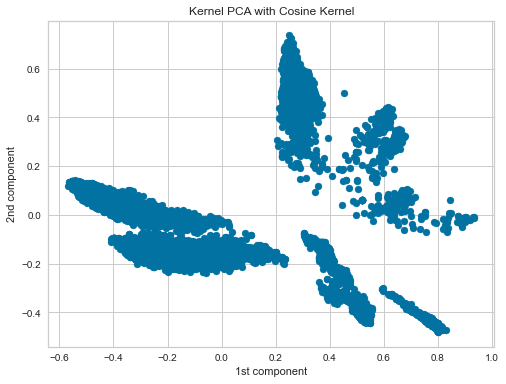

In [110]:
kpca = KernelPCA(n_components=2, kernel='cosine', gamma=0.1,random_state=0)
X_kpca = kpca.fit_transform(df_scaled1)

plt.figure(figsize=(8, 6))
plt.scatter(X_kpca[:, 0], X_kpca[:, 1])
plt.title("Kernel PCA with Cosine Kernel")
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

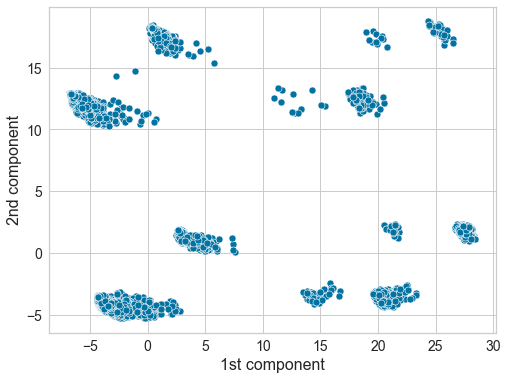

In [111]:
pca = PCA(n_components=2,random_state=0)
df_pca = pca.fit_transform(df_scaled1)
df_pca = pd.DataFrame(data=df_pca, columns=['PC1', 'PC2'])

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=df_pca)
# plt.title('PCA scatter plot')
plt.xlabel('1st component', fontsize=16)
plt.ylabel('2nd component', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

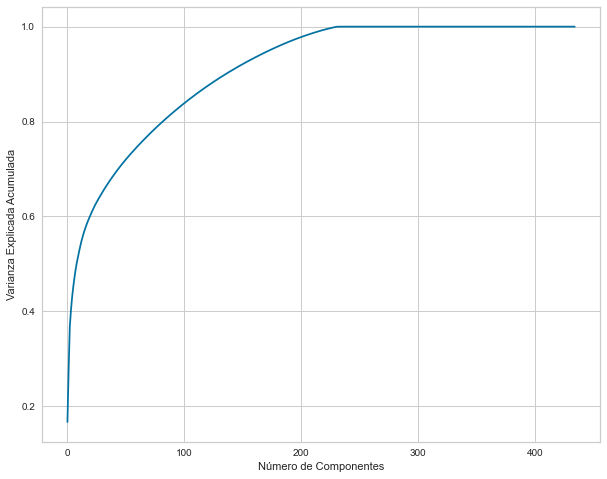

In [112]:
pca = PCA(random_state=0)
pca.fit(df_scaled1)

plt.figure(figsize=(10,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.grid(True)
plt.show()

In [113]:
# pca = PCA(n_components=100,random_state=0)
# df_pca = pca.fit_transform(df_scaled1)
kpca = KernelPCA(n_components=100, kernel='cosine', gamma=0.1,random_state=0)
df_pca = kpca.fit_transform(df_scaled1)

In [114]:
from sklearn.mixture import GaussianMixture

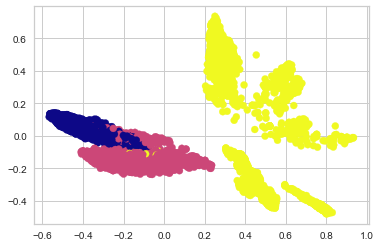

In [115]:
gmm = GaussianMixture(random_state=0,n_components=3)
cluster_labels = gmm.fit_predict(df_pca)
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=cluster_labels, cmap='plasma')

In [124]:
# km = KMeans(random_state=0)
# visualizer = KElbowVisualizer(km, k=(2,10), locate_elbow=True)

In [106]:
# visualizer.fit(df_pca)
# visualizer.show()

# Calculando clusters

In [116]:
n_components = np.arange(1, 11)

In [117]:
aic_values = []
bic_values = []

# Ajustar el modelo y calcular AIC/BIC para cada número de clústeres
for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(df_pca)
    aic_values.append(gmm.aic(df_pca))
    bic_values.append(gmm.bic(df_pca))

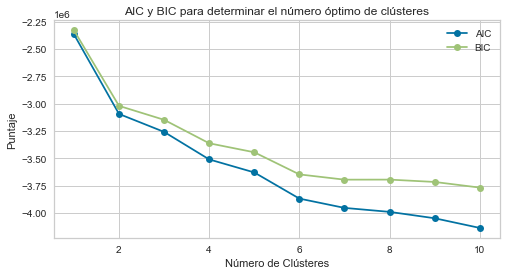

In [118]:
plt.figure(figsize=(8, 4))
plt.plot(n_components, aic_values, label='AIC', marker='o')
plt.plot(n_components, bic_values, label='BIC', marker='o')
plt.xlabel('Número de Clústeres')
plt.ylabel('Puntaje')
plt.legend()
plt.title('AIC y BIC para determinar el número óptimo de clústeres')
plt.show()

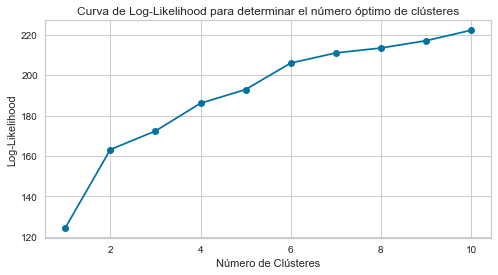

In [119]:
log_likelihoods = []

# Calcular log-likelihood para cada número de clústeres
for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(df_pca)
    log_likelihoods.append(gmm.score(df_pca))  # Promedio de log-likelihood

# Graficar la log-likelihood
plt.figure(figsize=(8, 4))
plt.plot(n_components, log_likelihoods, marker='o')
plt.xlabel('Número de Clústeres')
plt.ylabel('Log-Likelihood')
plt.title('Curva de Log-Likelihood para determinar el número óptimo de clústeres')
plt.show()

In [120]:
df_rev1 = dfper[dfper['target'].isin([1,2])].copy()

In [121]:
df_rev1['segmento'] = cluster_labels

In [122]:
df_rev1['segmento'].value_counts()

2    3698
1    3321
0    2525
Name: segmento, dtype: int64

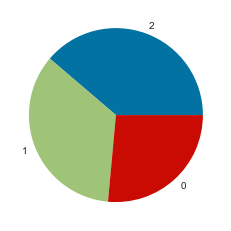

In [123]:
plt.pie(df_rev1['segmento'].value_counts().values,labels=df_rev1['segmento'].value_counts().index)
plt.show()

# Graficando resultados

In [124]:
def grafica_por_dimension(df,
                          code_dimension,
                          code_question,
                          num_partitions,
                          max_char_per_line=50,
                          figsize=(10,6),
                          title=None,
                          cat_omit=None,x_legend = 0.91,y_legend = 0.5):
    if title == None:
        title = m_per[m_per['code']==f'{code_question}']['pregunta'].values[0]
    if cat_omit==None:
        agg_data = df.groupby([f'{code_dimension}',f'{code_question}']).agg(CTD_PERSONAS = ('ad_001','count')).reset_index()
        total_counts = df.groupby(f'{code_dimension}').agg(TOTAL_PERSONAS=('ad_001', 'count')).reset_index()
    elif cat_omit!=None:
        tmp = df[df[f'{code_question}']!=f'{cat_omit}']
        agg_data = tmp.groupby([f'{code_dimension}',f'{code_question}']).agg(CTD_PERSONAS = ('ad_001','count')).reset_index()
        total_counts = tmp.groupby(f'{code_dimension}').agg(TOTAL_PERSONAS=('ad_001', 'count')).reset_index()

    
    agg_data = agg_data.merge(total_counts, on=f'{code_dimension}',how='left')
    agg_data['PROPORCION'] = agg_data['CTD_PERSONAS'] / agg_data['TOTAL_PERSONAS']
    
    if len(title) > max_char_per_line:
        title = '\n'.join(textwrap.wrap(title, break_long_words=False, max_lines=num_partitions))

    category_mapping = {category: idx + 1 for idx, category in enumerate(agg_data[code_dimension].unique())}
    agg_data['category_num'] = agg_data[code_dimension].map(category_mapping)

    plt.figure(figsize=figsize)
    sns.barplot(data=agg_data, x=f'category_num', y='PROPORCION', hue=f'{code_question}')
    plt.title(f'{title}')
    plt.ylabel('Proporción (%)')
    plt.xlabel(f'{code_dimension}')
    plt.legend(title='Respuestas', bbox_to_anchor=(1.00, 1), loc='upper left')
    plt.xticks(rotation=0, ha='center', fontsize=10)
    
    category_legend = [f'{num}: {category}' for category, num in category_mapping.items()]
    plt.figtext(x_legend, y_legend, '\n'.join(category_legend), fontsize=10, ha='left')
    
    plt.show()

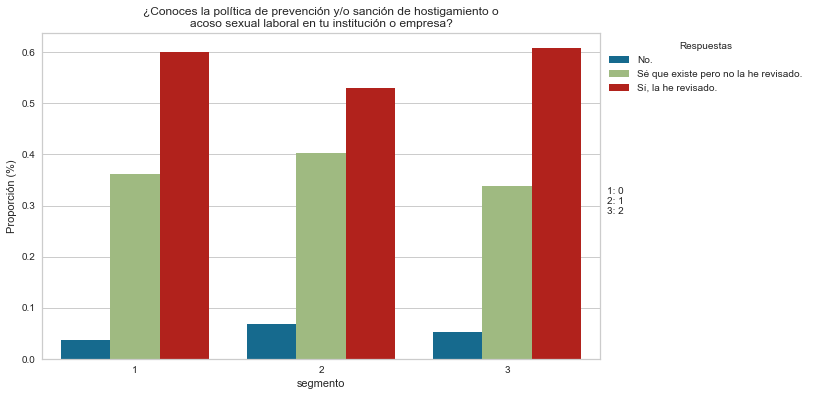

In [127]:
grafica_por_dimension(df_rev1,'segmento','sp_001',3,cat_omit='Otro',y_legend=0.46)

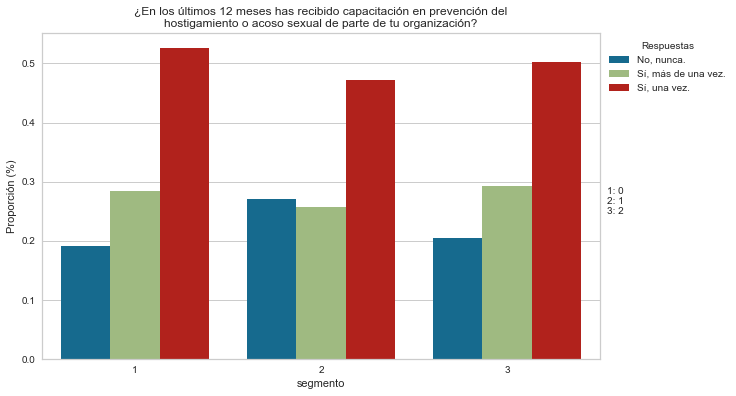

In [128]:
grafica_por_dimension(df_rev1,'segmento','sp_002',3,cat_omit='Otro',y_legend=0.46)

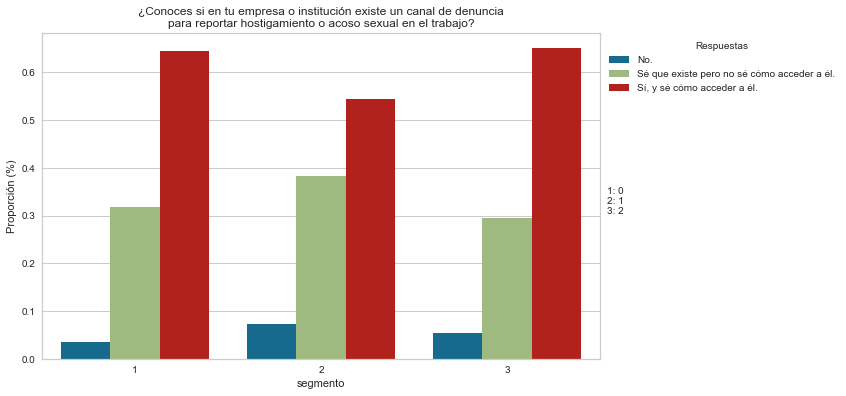

In [129]:
grafica_por_dimension(df_rev1,'segmento','sp_003',3,cat_omit='Otro',y_legend=0.46)

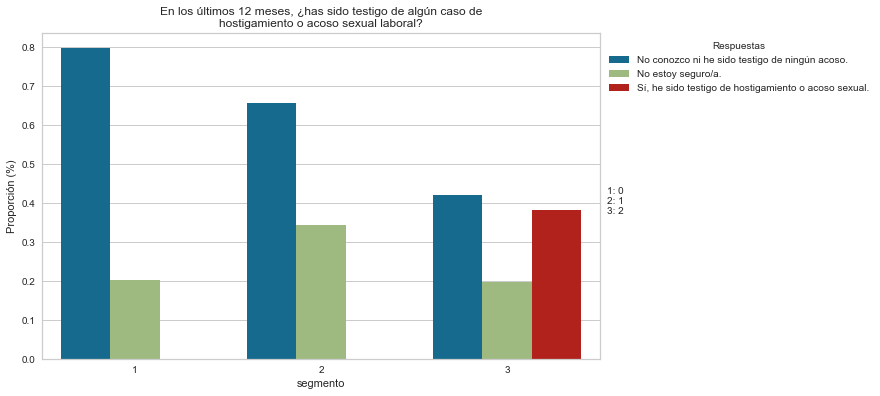

In [130]:
grafica_por_dimension(df_rev1,'segmento','td_001',3,cat_omit='Otro',y_legend=0.46)

In [154]:
df_rev1.groupby(['segmento','td_001'],dropna=False)['measurement_process_id'].count().to_frame().reset_index()

,segmento,td_001,measurement_process_id
0,0,No conozco ni he sido testigo de ningún acoso.,2014
1,0,No estoy seguro/a.,511
2,1,No conozco ni he sido testigo de ningún acoso.,2182
3,1,No estoy seguro/a.,1139
4,2,No conozco ni he sido testigo de ningún acoso.,1556
5,2,No estoy seguro/a.,728
6,2,"Sí, he sido testigo de hostigamiento o acoso s...",1414


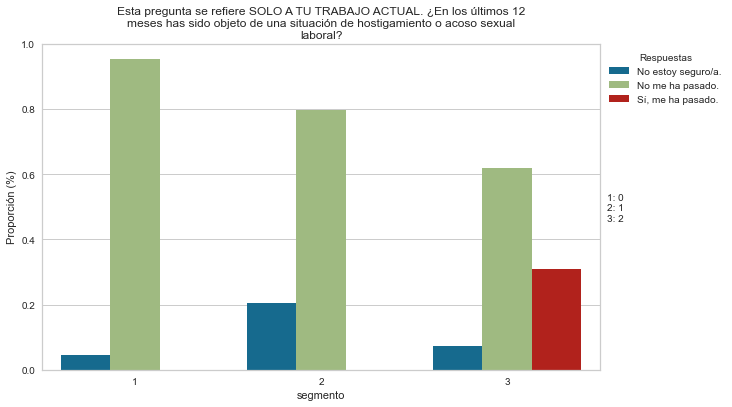

In [131]:
grafica_por_dimension(df_rev1,'segmento','ad_001',3,cat_omit='Otro',y_legend=0.47)

In [155]:
df_rev1.groupby(['segmento','ad_001'],dropna=False)['measurement_process_id'].count().to_frame().reset_index()

,segmento,ad_001,measurement_process_id
0,0,No estoy seguro/a.,118
1,0,No me ha pasado.,2407
2,1,No estoy seguro/a.,676
3,1,No me ha pasado.,2645
4,2,No estoy seguro/a.,272
5,2,No me ha pasado.,2288
6,2,"Sí, me ha pasado.",1138


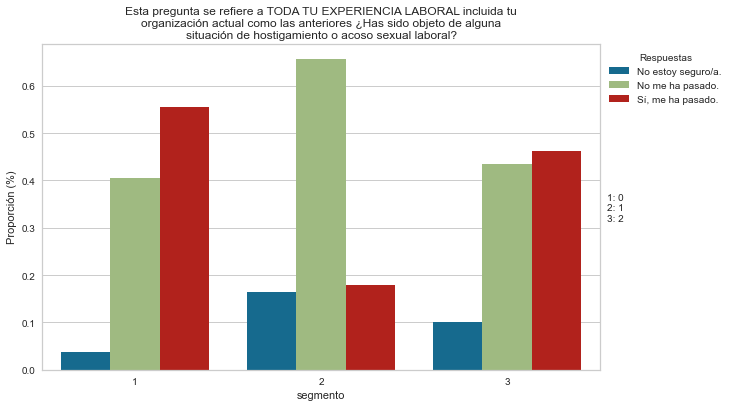

In [132]:
grafica_por_dimension(df_rev1,'segmento','ad_014',3,cat_omit='Otro',y_legend=0.47)

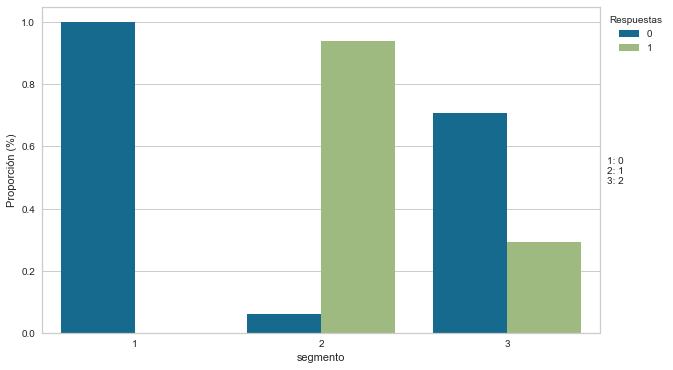

In [211]:
grafica_por_dimension(df_rev1,'segmento','Acoso_Tecnico',3,cat_omit='Otro',y_legend=0.47,title='')

In [213]:
df_rev1.groupby(['segmento','Acoso_Tecnico']).agg(cantidad=('measurement_process_id','count')).reset_index().pivot_table(values='cantidad',columns='Acoso_Tecnico',index='segmento').reset_index()

Acoso_Tecnico,segmento,0,1
0,0,2525.0,NaN
1,1,200.0,3121.0
2,2,2613.0,1085.0


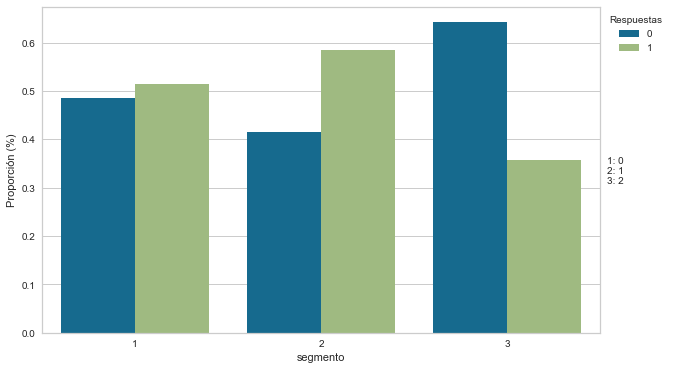

In [212]:
grafica_por_dimension(df_rev1,'segmento','Testigo_Tecnico',3,cat_omit='Otro',y_legend=0.47,title='')

In [214]:
df_rev1.groupby(['segmento','Testigo_Tecnico']).agg(cantidad=('measurement_process_id','count')).reset_index().pivot_table(values='cantidad',columns='Testigo_Tecnico',index='segmento').reset_index()

Testigo_Tecnico,segmento,0,1
0,0,1225,1300
1,1,1377,1944
2,2,2376,1322


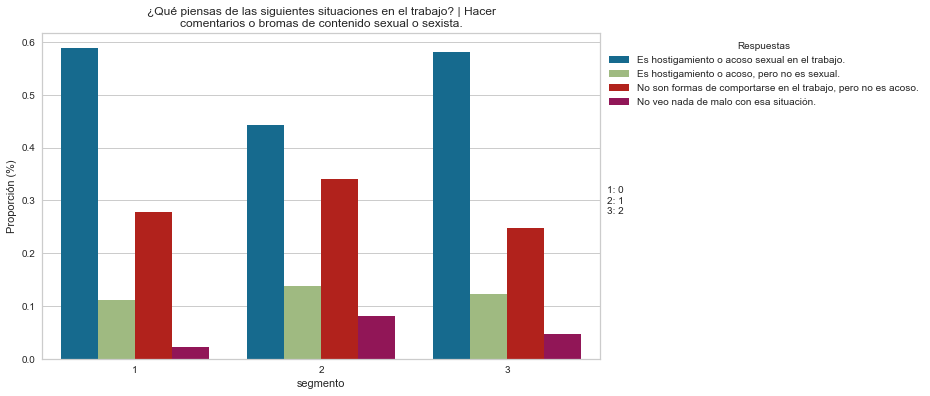

In [133]:
grafica_por_dimension(df_rev1,'segmento','tol_001',3,cat_omit='Otro',y_legend=0.46)

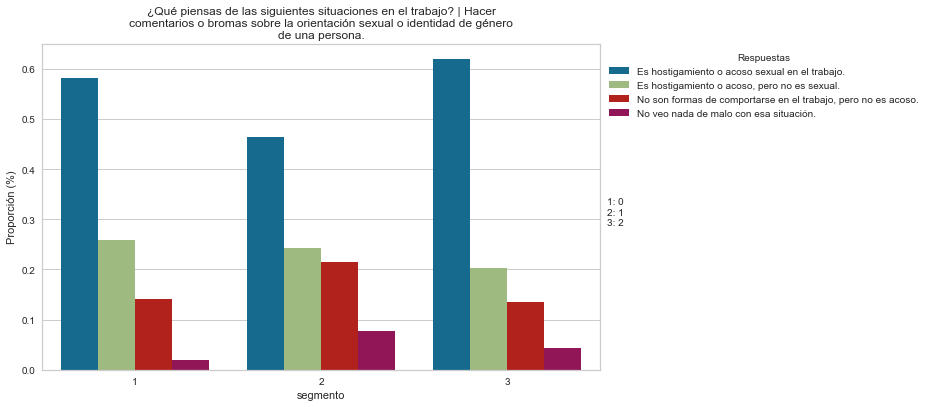

In [134]:
grafica_por_dimension(df_rev1,'segmento','tol_002',3,cat_omit='Otro',y_legend=0.46)

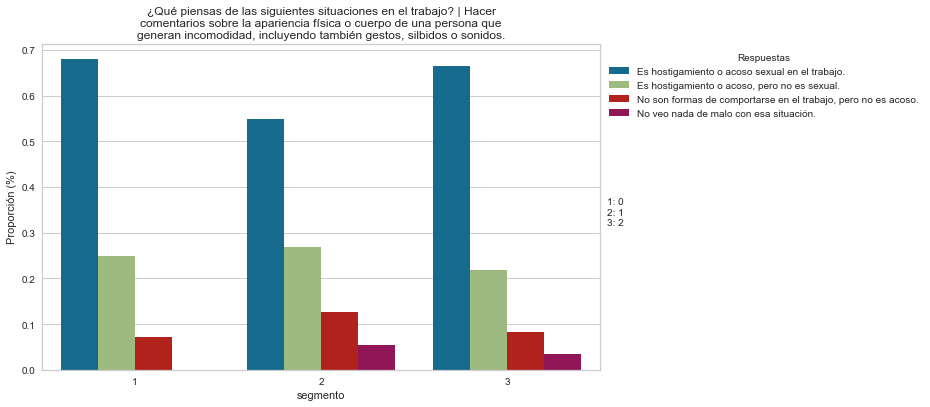

In [135]:
grafica_por_dimension(df_rev1,'segmento','tol_003',3,cat_omit='Otro',y_legend=0.46)

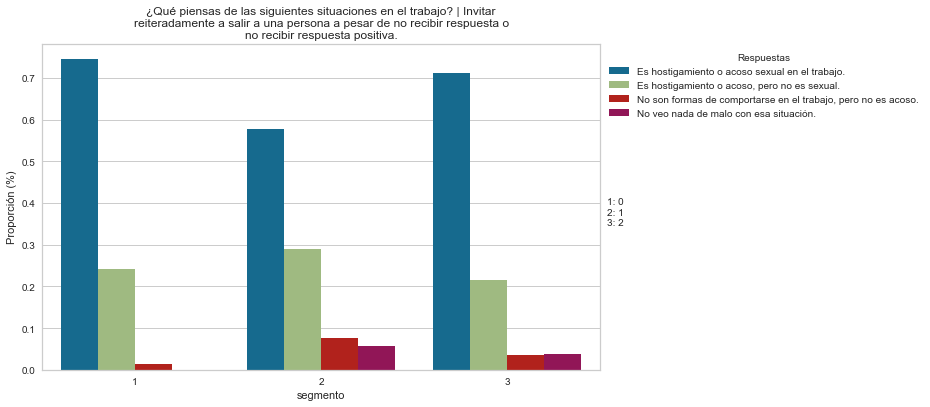

In [136]:
grafica_por_dimension(df_rev1,'segmento','tol_004',3,cat_omit='Otro',y_legend=0.46)

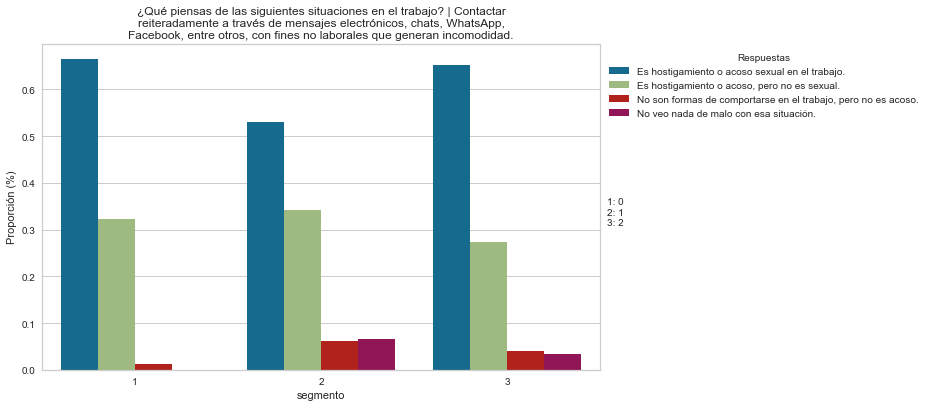

In [197]:
grafica_por_dimension(df_rev1,'segmento','tol_005',3,cat_omit='Otro',y_legend=0.46)

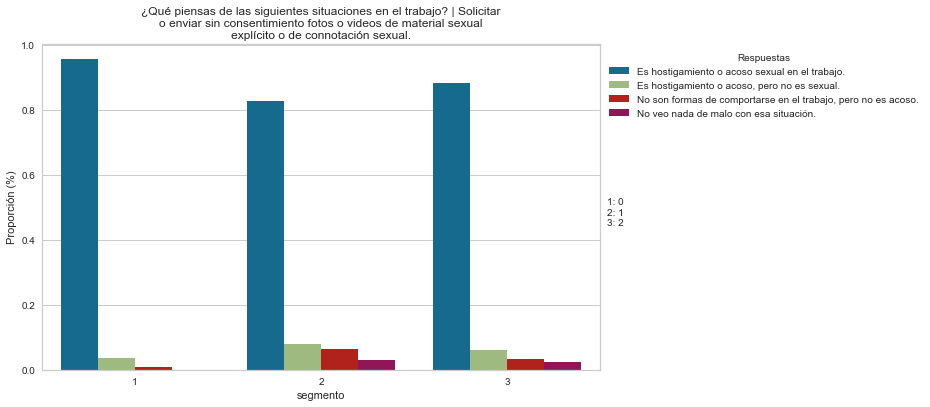

In [198]:
grafica_por_dimension(df_rev1,'segmento','tol_006',3,cat_omit='Otro',y_legend=0.46)

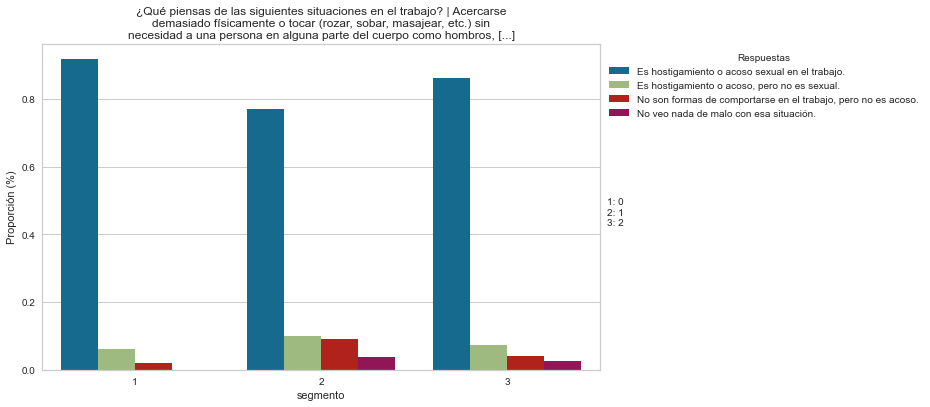

In [199]:
grafica_por_dimension(df_rev1,'segmento','tol_007',3,cat_omit='Otro',y_legend=0.46)

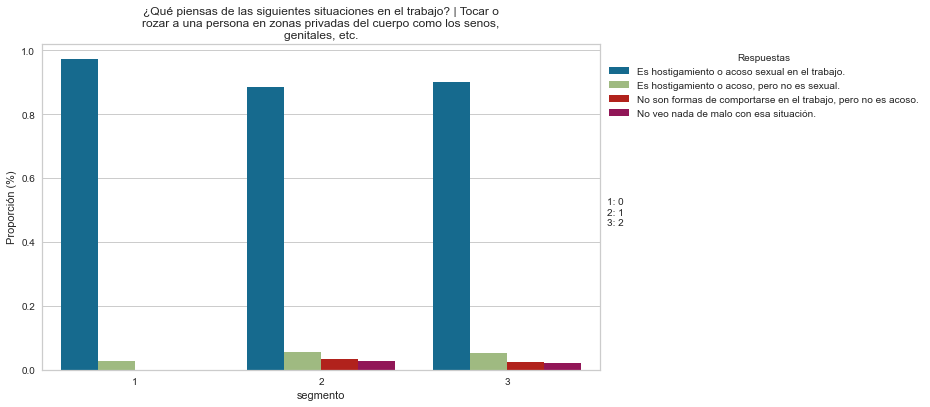

In [200]:
grafica_por_dimension(df_rev1,'segmento','tol_008',3,cat_omit='Otro',y_legend=0.46)

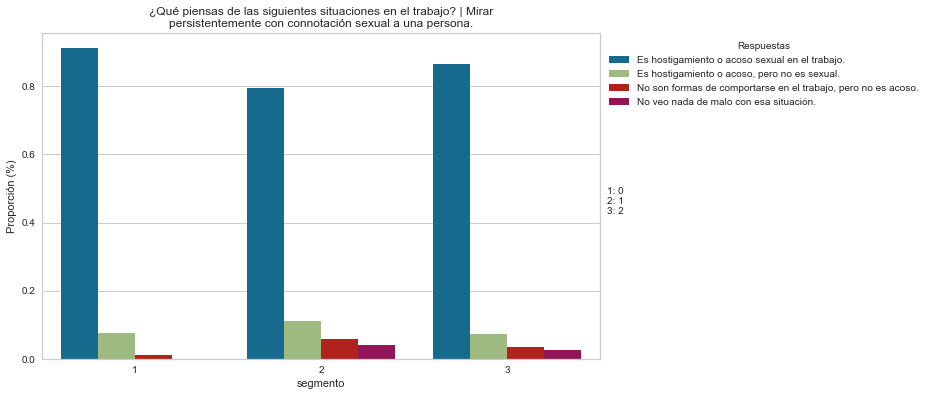

In [201]:
grafica_por_dimension(df_rev1,'segmento','tol_009',3,cat_omit='Otro',y_legend=0.46)

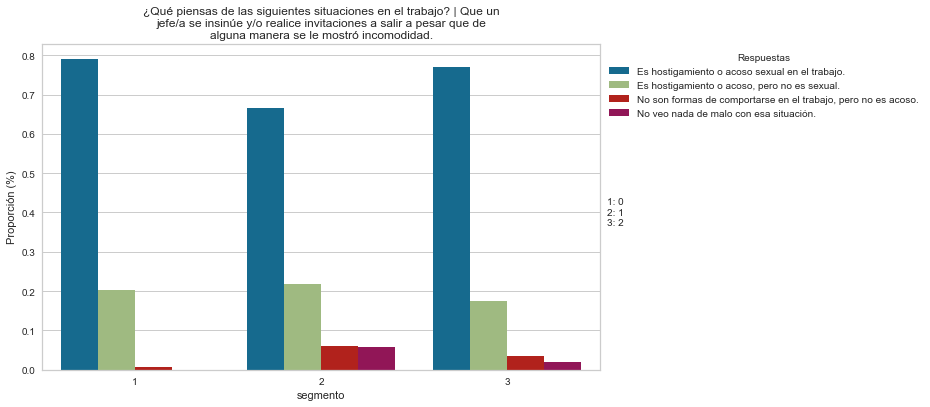

In [202]:
grafica_por_dimension(df_rev1,'segmento','tol_010',3,cat_omit='Otro',y_legend=0.46)

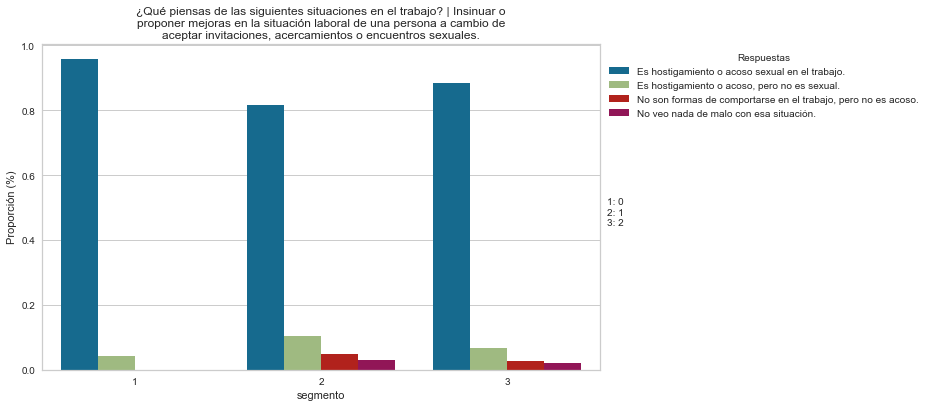

In [203]:
grafica_por_dimension(df_rev1,'segmento','tol_011',3,cat_omit='Otro',y_legend=0.46)

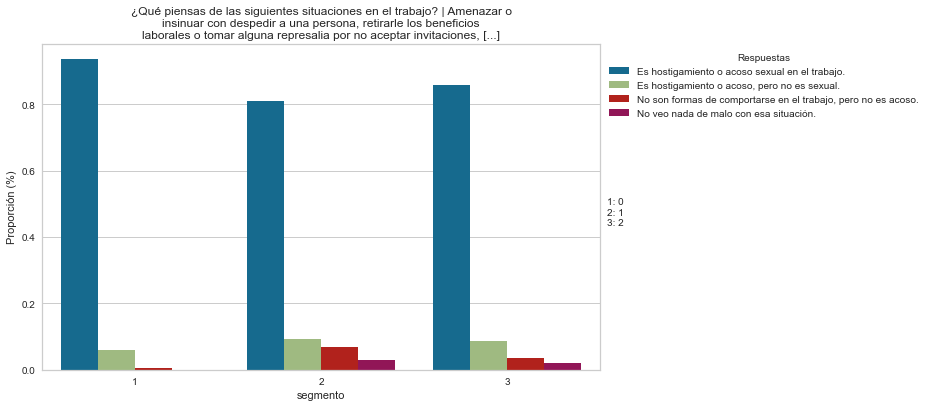

In [204]:
grafica_por_dimension(df_rev1,'segmento','tol_012',3,cat_omit='Otro',y_legend=0.46)

In [156]:
tolerancia = [col for col in dfper.columns if 'tol_' in col]
df_rev1['flg_tol_neg'] = df_rev1[tolerancia].apply(lambda row: 1 if any(x in ['No veo nada de malo con esa situación.', 'No son formas de comportarse en el trabajo, pero no es acoso.'] for x in row) else 0, axis=1)

In [166]:
df_rev1.groupby(['segmento','flg_tol_neg']).agg(cantidad=('measurement_process_id','count')).reset_index().pivot_table(values='cantidad',columns='flg_tol_neg',index='segmento').reset_index()

flg_tol_neg,segmento,0,1
0,0,1554,971
1,1,1366,1955
2,2,2173,1525


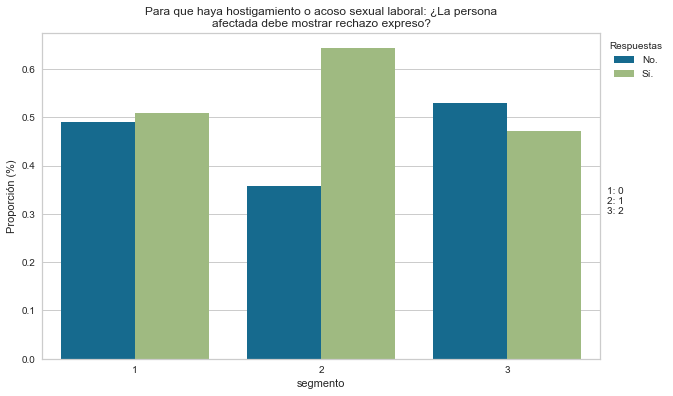

In [137]:
grafica_por_dimension(df_rev1,'segmento','cpt_001',3,cat_omit='Otro',y_legend=0.46)

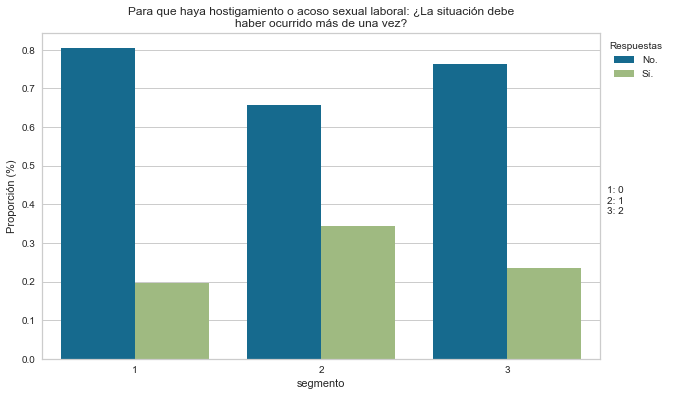

In [138]:
grafica_por_dimension(df_rev1,'segmento','cpt_002',3,cat_omit='Otro',y_legend=0.46)

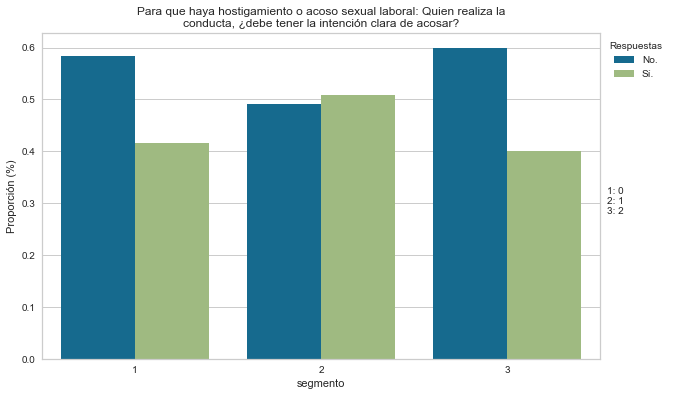

In [139]:
grafica_por_dimension(df_rev1,'segmento','cpt_003',3,cat_omit='Otro',y_legend=0.46)

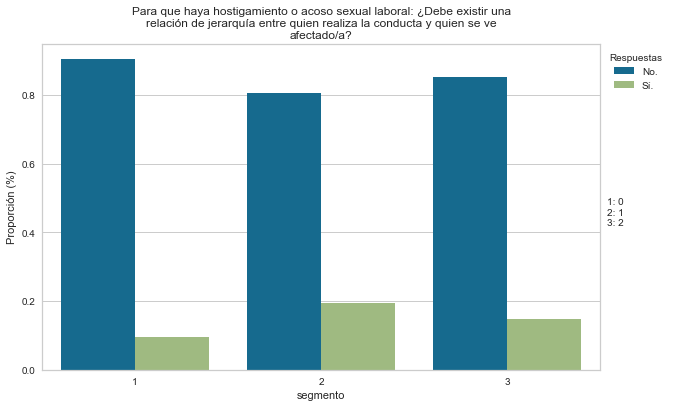

In [140]:
grafica_por_dimension(df_rev1,'segmento','cpt_004',3,cat_omit='Otro',y_legend=0.46)

In [205]:
tolerancia = ['cpt_002','cpt_004','cpt_001','cpt_003']
df_rev1['flg_tol_neg'] = df_rev1[tolerancia].apply(lambda row: 1 if any(x in ['No.'] for x in row) else 0, axis=1)

In [206]:
df_rev1.groupby(['segmento','flg_tol_neg']).agg(cantidad=('measurement_process_id','count')).reset_index().pivot_table(values='cantidad',columns='flg_tol_neg',index='segmento').reset_index()

flg_tol_neg,segmento,0,1
0,0,129,2396
1,1,367,2954
2,2,329,3369


In [169]:
tolerancia = ['cpt_002','cpt_004']
df_rev1['flg_tol_neg'] = df_rev1[tolerancia].apply(lambda row: 1 if any(x in ['No.'] for x in row) else 0, axis=1)

In [170]:
df_rev1.groupby(['segmento','flg_tol_neg']).agg(cantidad=('measurement_process_id','count')).reset_index().pivot_table(values='cantidad',columns='flg_tol_neg',index='segmento').reset_index()

flg_tol_neg,segmento,0,1
0,0,160,2365
1,1,443,2878
2,2,384,3314


In [171]:
tolerancia = ['cpt_001','cpt_003']
df_rev1['flg_tol_neg'] = df_rev1[tolerancia].apply(lambda row: 1 if any(x in ['No.'] for x in row) else 0, axis=1)

In [172]:
df_rev1.groupby(['segmento','flg_tol_neg']).agg(cantidad=('measurement_process_id','count')).reset_index().pivot_table(values='cantidad',columns='flg_tol_neg',index='segmento').reset_index()

flg_tol_neg,segmento,0,1
0,0,791,1734
1,1,1392,1929
2,2,1135,2563


In [179]:
df_rev1.groupby(['segmento','cpt_001']).agg(cantidad=('measurement_process_id','count')).reset_index().pivot_table(values='cantidad',columns='cpt_001',index='segmento').reset_index()

cpt_001,segmento,No.,Sí.
0,0,1239,1286
1,1,1185,2136
2,2,1956,1741


In [180]:
df_rev1.groupby(['segmento','cpt_002']).agg(cantidad=('measurement_process_id','count')).reset_index().pivot_table(values='cantidad',columns='cpt_002',index='segmento').reset_index()

cpt_002,segmento,No.,Sí.
0,0,2031,494
1,1,2183,1138
2,2,2825,872


In [181]:
df_rev1.groupby(['segmento','cpt_003']).agg(cantidad=('measurement_process_id','count')).reset_index().pivot_table(values='cantidad',columns='cpt_003',index='segmento').reset_index()

cpt_003,segmento,No.,Sí.
0,0,1475,1050
1,1,1629,1692
2,2,2215,1482


In [182]:
df_rev1.groupby(['segmento','cpt_004']).agg(cantidad=('measurement_process_id','count')).reset_index().pivot_table(values='cantidad',columns='cpt_004',index='segmento').reset_index()

cpt_004,segmento,No.,Sí.
0,0,2283,242
1,1,2680,641
2,2,3153,544


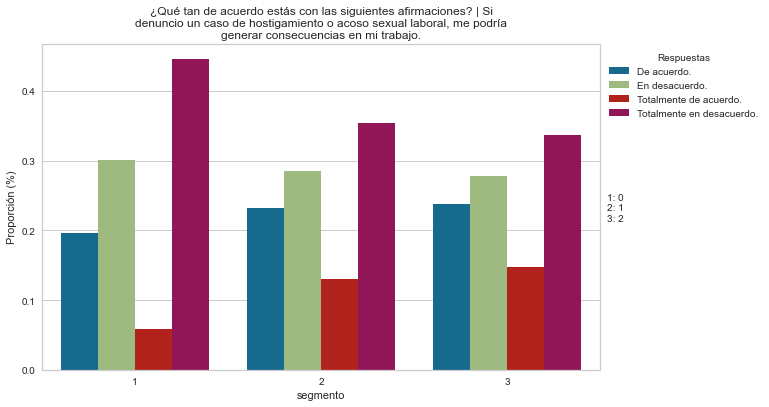

In [141]:
grafica_por_dimension(df_rev1,'segmento','con_001',3,cat_omit='Otro',y_legend=0.47)

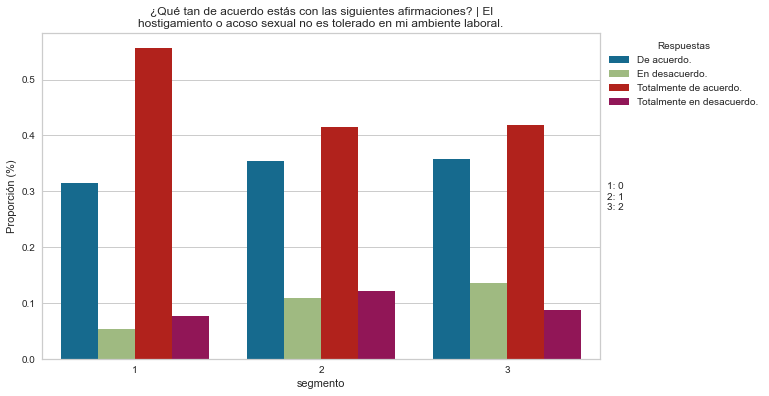

In [142]:
grafica_por_dimension(df_rev1,'segmento','con_004',3,cat_omit='Otro',y_legend=0.47)

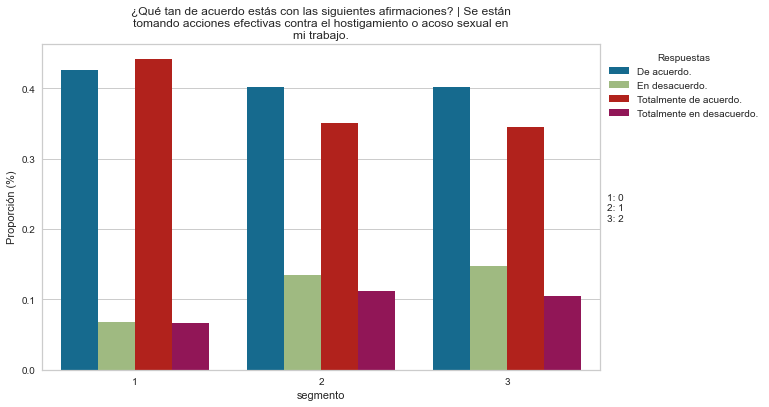

In [143]:
grafica_por_dimension(df_rev1,'segmento','con_006',3,cat_omit='Otro',y_legend=0.47)

In [189]:
tolerancia = ['con_004','con_006']
df_rev1['flg_con_neg'] = df_rev1[tolerancia].apply(lambda row: 1 if any(x in ['De acuerdo.','Totalmente de acuerdo.'] for x in row) else 0, axis=1)

In [190]:
df_rev1.groupby(['segmento','flg_con_neg']).agg(cantidad=('measurement_process_id','count')).reset_index().pivot_table(values='cantidad',columns='flg_con_neg',index='segmento').reset_index()

flg_con_neg,segmento,0,1
0,0,146,2379
1,1,495,2826
2,2,545,3153


In [191]:
tolerancia = ['con_001','con_002','con_003','con_005']
df_rev1['flg_con_neg'] = df_rev1[tolerancia].apply(lambda row: 1 if any(x in ['De acuerdo.','Totalmente de acuerdo.'] for x in row) else 0, axis=1)

In [192]:
df_rev1.groupby(['segmento','flg_con_neg']).agg(cantidad=('measurement_process_id','count')).reset_index().pivot_table(values='cantidad',columns='flg_con_neg',index='segmento').reset_index()

flg_con_neg,segmento,0,1
0,0,1505,1020
1,1,1463,1858
2,2,1640,2058


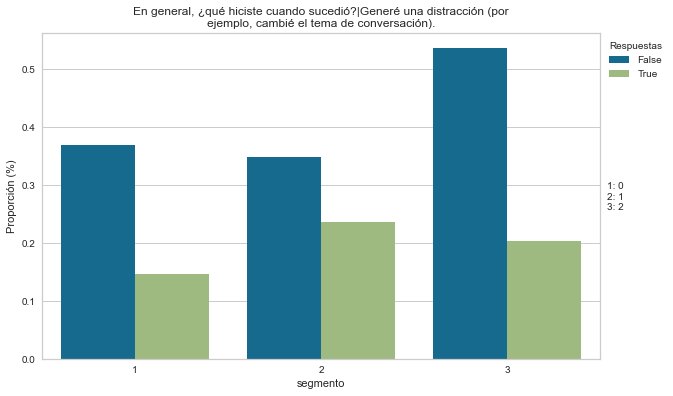

In [144]:
grafica_por_dimension(df_rev1,'segmento','act_001',3,cat_omit='Otro',y_legend=0.47)

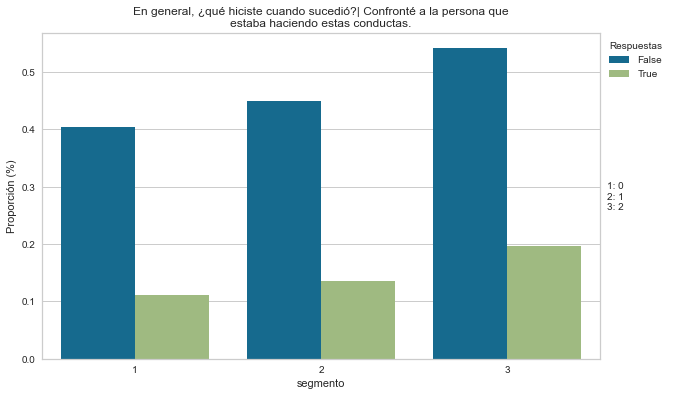

In [145]:
grafica_por_dimension(df_rev1,'segmento','act_002',3,cat_omit='Otro',y_legend=0.47)

In [217]:
testigo_activo = ['act_001', 'act_002', 'act_003', 'act_004', 'act_005']
testigo_pasivo = ['act_006', 'act_007', 'act_008']
df_rev1['testigo_activo_flg_pos'] = df_rev1[testigo_activo].apply(lambda row: 1 if any(x in [True] for x in row) else 0, axis=1)
df_rev1['testigo_pasivo_flg_pos'] = df_rev1[testigo_pasivo].apply(lambda row: 1 if any(x in [True] for x in row) else 0, axis=1)

In [220]:
df_rev1.groupby(['segmento','testigo_activo_flg_pos'],dropna=False).agg(cantidad=('measurement_process_id','count')).reset_index().pivot_table(values='cantidad',columns='testigo_activo_flg_pos',index='segmento').reset_index()

testigo_activo_flg_pos,segmento,0,1
0,0,1742,783
1,1,1965,1356
2,2,1692,2006


In [219]:
df_rev1.groupby(['segmento','testigo_pasivo_flg_pos']).agg(cantidad=('measurement_process_id','count')).reset_index().pivot_table(values='cantidad',columns='testigo_pasivo_flg_pos',index='segmento').reset_index()

testigo_pasivo_flg_pos,segmento,0,1
0,0,1931,594
1,1,2516,805
2,2,2676,1022


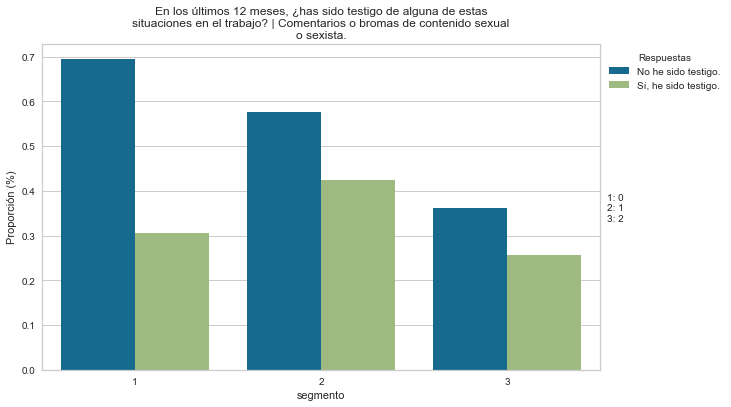

In [149]:
grafica_por_dimension(df_rev1,'segmento','tt_001',3,cat_omit='Otro',y_legend=0.47)

In [ ]:
# Generar variable de acoso total (indique quien es declarado y quien es tecnico)

In [223]:
df_rev1['ad_001'].value_counts()

No me ha pasado.      7340
Sí, me ha pasado.     1138
No estoy seguro/a.    1066
Name: ad_001, dtype: int64

In [224]:
df_rev1['Acoso_Tecnico'].value_counts()

0    5338
1    4206
Name: Acoso_Tecnico, dtype: int64

In [225]:
def acoso_total_col(ad_001,acoso_tecnico):
    if ad_001 == 'Sí, me ha pasado.':
        return 'acoso declarado'
    elif acoso_tecnico == 1:
        return 'acoso tecnico'
    else:
        return 'otro'

In [228]:
df_rev1['Acoso_Total_Col'] = df_rev1.apply(lambda x: acoso_total_col(x['ad_001'],x['Acoso_Tecnico']),axis=1)

In [229]:
df_rev1.groupby(['segmento','Acoso_Total_Col']).agg(cantidad=('measurement_process_id','count')).reset_index().pivot_table(values='cantidad',columns='Acoso_Total_Col',index='segmento').reset_index()

Acoso_Total_Col,segmento,acoso declarado,acoso tecnico,otro
0,0,NaN,NaN,2525.0
1,1,NaN,3121.0,200.0
2,2,1138.0,1084.0,1476.0


In [235]:
df_rev1['td_001'].value_counts().index

Index(['No conozco ni he sido testigo de ningún acoso.', 'No estoy seguro/a.',
       'Sí, he sido testigo de hostigamiento o acoso sexual.'],
      dtype='object')

In [242]:
def testigo_total_col(ad_001,acoso_tecnico):
    if ad_001 == 1:
        return 'testigo declarado'
    elif acoso_tecnico == 1:
        return 'testigo tecnico'
    else:
        return 'otro'

In [248]:
df_rev1['Testigo_Total_Col'] = df_rev1.apply(lambda x: testigo_total_col(x['Testigo_Declarado'],x['Testigo_Tecnico']),axis=1)

In [251]:
df_rev1.groupby(['segmento','Testigo_Total_Col']).agg(cantidad=('measurement_process_id','count')).reset_index().pivot_table(values='cantidad',columns='Testigo_Total_Col',index='segmento').reset_index()

Testigo_Total_Col,segmento,otro,testigo declarado,testigo tecnico
0,0,1225.0,NaN,1300.0
1,1,1377.0,NaN,1944.0
2,2,962.0,1414.0,1322.0


In [252]:
df_rev1.groupby(['segmento','Testigo_Total']).agg(cantidad=('measurement_process_id','count')).reset_index().pivot_table(values='cantidad',columns='Testigo_Total',index='segmento').reset_index()

Testigo_Total,segmento,0,1
0,0,1225,1300
1,1,1377,1944
2,2,962,2736


In [254]:
tolerancia = ['aad_001', 'aad_002', 'aad_003', 'aad_004', 'aad_005', 'aad_008']
df_rev1['aad_flg_pos'] = df_rev1[tolerancia].apply(lambda row: 1 if any(x in ['Sí.'] for x in row) else 0, axis=1)

In [255]:
df_rev1.groupby(['segmento','aad_flg_pos']).agg(cantidad=('measurement_process_id','count')).reset_index().pivot_table(values='cantidad',columns='aad_flg_pos',index='segmento').reset_index()

aad_flg_pos,segmento,0,1
0,0,2525.0,NaN
1,1,3321.0,NaN
2,2,2659.0,1039.0


In [ ]:
# Posible siguiente paso: intentar con depuracion de variables de acoso declarado AD, PAD, 